In [25]:
import pandas as pd

# Load the Parquet file
df = pd.read_parquet("gps_data_relaxed_parameters_more.parquet")

# Show first few rows
print(df.head())

# Show column names and data types
print(df.info())


   id_tracking         id                time  type  sequence comment  speed  \
0        88926  107329270 2024-08-01 05:18:02     0        43    None    0.0   
1        88926  107329271 2024-08-01 05:18:05     0        44    None    0.0   
2        88926  107329272 2024-08-01 05:18:08     0        45    None    0.0   
3        88926  107329273 2024-08-01 05:18:10     0        46    None    0.0   
4        88926  107329274 2024-08-01 05:18:12     0        47    None    0.0   

   heading  duration  block_type   log   latitude  longitude  altitude  \
0      0.0         0           0  None  47.069676  15.781769       0.0   
1      0.0         0           0  None  47.069235  15.781806       0.0   
2      0.0         0           0  None  47.068783  15.781572       0.0   
3      0.0         0           0  None  47.068537  15.781260       0.0   
4      0.0         0           0  None  47.068364  15.780865       0.0   

   meta_tag meta_value  
0         0             
1         0             

In [26]:
print(df.describe())


         id_tracking            id                           time  \
count  129967.000000  1.299670e+05                         129967   
mean    47936.187517  5.997821e+07  2021-11-26 03:31:04.219448064   
min        59.000000  6.657800e+04            2014-09-19 05:01:38   
25%     21358.000000  3.306266e+07            2020-06-05 06:18:27   
50%     45839.000000  6.074818e+07            2022-02-23 14:24:33   
75%     74214.000000  8.763972e+07            2023-11-02 05:58:57   
max    101182.000000  1.275922e+08            2025-03-04 12:28:52   
std     29781.263136  3.438240e+07                            NaN   

                type       sequence     speed   heading  duration  block_type  \
count  129967.000000  129967.000000  129967.0  129967.0  129967.0    129967.0   
mean        3.341271     101.565282       0.0       0.0       0.0         0.0   
min         0.000000       0.000000       0.0       0.0       0.0         0.0   
25%         0.000000      38.000000       0.0       0.

In [27]:
print(df.isnull().sum())


id_tracking         0
id                  0
time                0
type                0
sequence            0
comment        129967
speed               0
heading             0
duration            0
block_type          0
log            129967
latitude            0
longitude           0
altitude            0
meta_tag            0
meta_value          0
dtype: int64


In [28]:
waypoints_per_tracking = df.groupby("id_tracking").size()
print(waypoints_per_tracking.describe())  


count     850.000000
mean      152.902353
std        88.423644
min        13.000000
25%       103.000000
50%       142.000000
75%       183.000000
max      1168.000000
dtype: float64


In [29]:
avg_speed_per_tracking = df.groupby("id_tracking")["speed"].mean()
print(avg_speed_per_tracking.describe())


count    850.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: speed, dtype: float64


In [30]:
import numpy as np

# Compute rough distance traveled using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Compute distance per row
df['prev_lat'] = df.groupby("id_tracking")['latitude'].shift(1)
df['prev_lon'] = df.groupby("id_tracking")['longitude'].shift(1)

df['distance_km'] = df.apply(lambda row: haversine(row.prev_lat, row.prev_lon, row.latitude, row.longitude)
                             if pd.notnull(row.prev_lat) else 0, axis=1)

# Aggregate distance per tracking
total_distance_per_tracking = df.groupby("id_tracking")["distance_km"].sum()
print(total_distance_per_tracking.describe())


count    850.000000
mean      15.500354
std       10.837762
min        4.523490
25%        8.531361
50%       13.038084
75%       19.640558
max      116.723056
Name: distance_km, dtype: float64


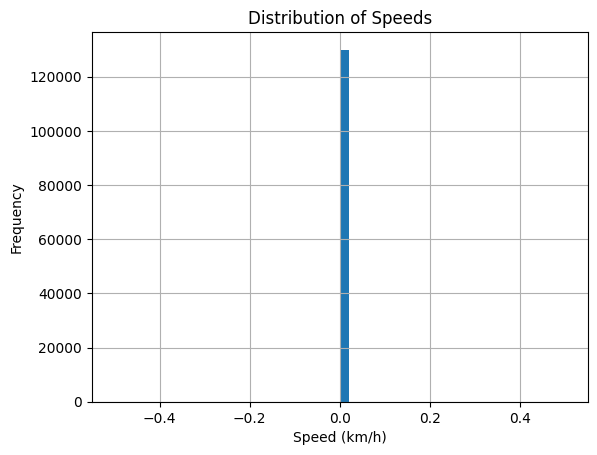

In [31]:
import matplotlib.pyplot as plt

df["speed"].hist(bins=50)
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Distribution of Speeds")
plt.show()


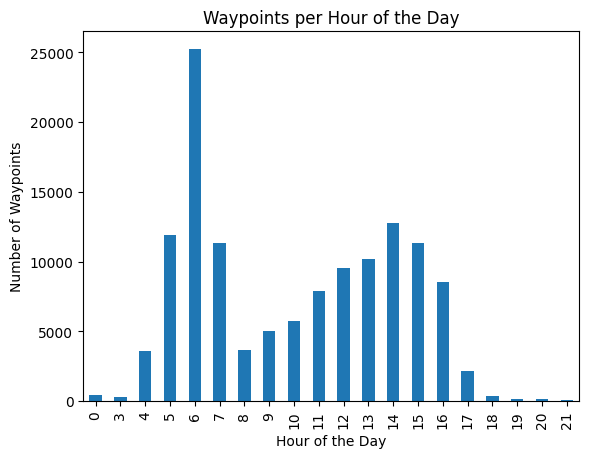

In [32]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Waypoints")
plt.title("Waypoints per Hour of the Day")
plt.show()


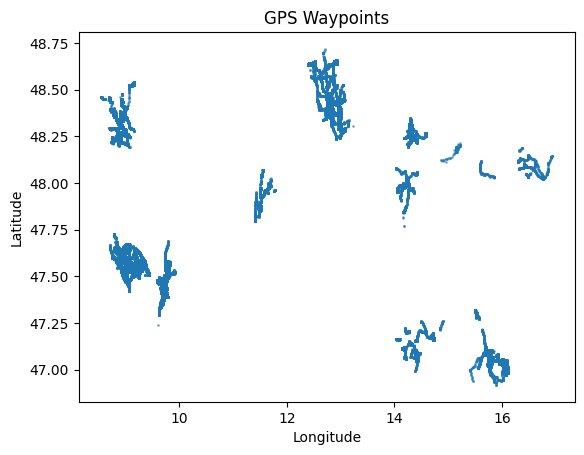

In [33]:
plt.scatter(df["longitude"], df["latitude"], alpha=0.5, s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GPS Waypoints")
plt.show()
